In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime

from utils import *
from bpy_utils import ManusData, get_fbx_creation_time

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure
from manus.sensors import SensorsLocation

In [3]:
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_2_fixed_wooden_cube/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_3_fixed_bottle_pose_1/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210727_woIMU/r3/"

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("recording:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".fbx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 07272021_3.hdf5
recording: 20210727_173327
manus_file: recording_2021-07-27_16-34-36.fbx


# Load data

In [4]:
%%capture

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

manus = ManusData(manus_pth, manopth_dir)

glove_sensor_path = os.path.join(manopth_dir, 'data/glove_vis_sensor_new.csv')
sensors_location = SensorsLocation(glove_sensor_path)

# Synchronize

#### Get timestamps

In [7]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
#pyfbx_i42_pth = "C:/Users/lucas/Desktop/UPC/MIT/pyfbx_i42-master/"
#ts_end = get_fbx_creation_time(manus_pth, pyfbx_i42_pth)
#ts_start = ts_end - len(manus) / 24
ts_manus = manus.get_ts(fps=19.67)

#### Find pressure camera offset


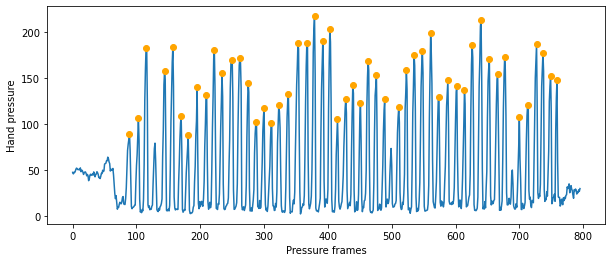

In [8]:
pressure.plot_peaks(height=80)

In [9]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=80)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Find manus camera offset


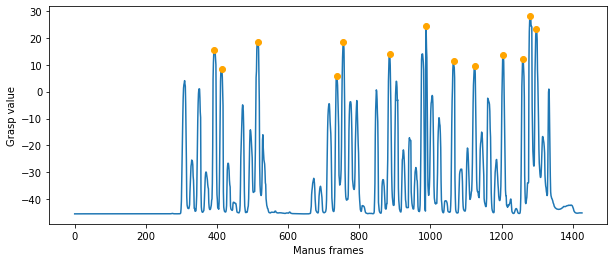

In [10]:
manus.plot_grasps(height=5)

In [11]:
# Index of first manus grasp peak 
idx_first_m = manus.get_grasps(height=5)[0]
# Timestamp of first manus grasp peak
ts_first_m = ts_manus[idx_first_m]

# Frame of first grasp in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
mc_offset = ts_first_m - ts_first_c

#### Synchronize pressure + camera + manus

In [12]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=mc_offset)

# Extract point clouds

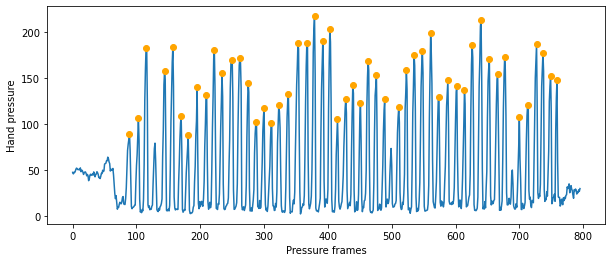

In [13]:
pressure.plot_peaks(height=80)

In [14]:
# Pressure frames where there are grasps
grasp_p_frames = pressure.get_peaks(height=80)
# Manus frames where there are grasps
grasp_m_frames = synchronize.pressure_to_manus(grasp_p_frames)

In [15]:
pointclouds = []
pointcloud_sensors = []

for grasp_p_frame in zip(grasp_p_frames):
    grasp_m_frame = synchronize.pressure_to_manus(grasp_p_frame)
    grasp_c_frame = synchronize.pressure_to_camera(grasp_p_frame)
    
    # Corner location of the AprilTag in world coordinates
    corners_w = apriltags.corners_w(idx=grasp_c_frame)
    
    if corners_w is not None:
        # Get manus verts at that frame
        hand_verts = manus.hand_verts_from_corners(grasp_m_frame, corners_w)
    
        # Get sensor location for that particular hand position
        sensors_xyz = sensors_location.from_hand_verts(hand_verts)

        # Get pressure at that particular frame
        response = pressure[grasp_p_frame]
        # Get pressure for each sensor index
        response = response.reshape(-1)[sensors_location.sensor_idx]
    
    
        idx_on = (response > 0.8).nonzero()
        pointclouds.append(sensors_xyz[idx_on,:][0])

        
all_pointclouds = np.concatenate( pointclouds, axis=0 )

In [22]:
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_pointclouds)
all_pcd.paint_uniform_color([0, 0, 0])
o3d.visualization.draw_geometries([all_pcd])

# Estimate object location

In [17]:

%%capture

pcd = stitched_pcd["000000"]

obj_name = "005_tomato_soup_can"
obj_name = "003_cracker_box"
obj_name = "006_mustard_bottle"
obj_name = "036_wood_block"

obj_pth = f"C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/{obj_name}.ply"

# Useful when running the cell multiple times
try:
    obj_mesh_t # obj_mesh_t exist in the current namespace
except NameError:
    transformation, obj_mesh_t = find_object_transformation(pcd, obj_pth)

In [23]:
o3d.visualization.draw_geometries([all_pcd,obj_mesh_t])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
